Import the python packages

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from PIL import Image
from IPython.display import display, clear_output
from utils.dataset import AdverCityDataset

In [2]:
plt.rcParams['figure.dpi'] = 150

Define the path to the desired scenario.

In [3]:
root = '/Users/Teo/Documents/2.Queens/1.Masters/1.Research/Assignment_1/advercity/ui_cd_s'

Create an instance of the AdverCityDataset class.

In [4]:
dataset = AdverCityDataset(root=root, car=0, cam=0)

These functions handle feature detection, matching, and pose estimation.

In [5]:
def detect_and_compute_features(image, detector):
    """Detect keypoints and compute descriptors using a given feature detector."""
    gray = np.array(image.convert('L'))  # Convert PIL image to grayscale
    keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def match_features(desc1, desc2, matcher):
    """Match descriptors between two consecutive frames."""
    matches = matcher.knnMatch(desc1, desc2, k=2)
    # Apply Lowe's ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    return good_matches

def get_pose_from_matches(kp1, kp2, good_matches, K):
    """Estimate motion using essential matrix and recover pose."""
    if len(good_matches) < 8:  # Minimum matches required for Essential Matrix
        return None, None
    
    # Extract matched keypoints
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    
    # Compute the Essential Matrix
    E, mask = cv.findEssentialMat(pts1, pts2, K, method=cv.RANSAC, prob=0.999, threshold=1.0)
    
    # Recover pose (rotation and translation) from Essential Matrix
    _, R, t, _ = cv.recoverPose(E, pts1, pts2, K)
    return R, t


Here we integrate all components of the pipeline and estimate motion over multiple frames.

Processing frame 0...
Processing frame 1...
Processing frame 2...
Processing frame 3...
Processing frame 4...
Processing frame 5...
Processing frame 6...
Processing frame 7...
Processing frame 8...
Processing frame 9...
Processing frame 10...
Processing frame 11...
Processing frame 12...
Processing frame 13...
Processing frame 14...
Processing frame 15...
Processing frame 16...
Processing frame 17...
Processing frame 18...
Processing frame 19...
Processing frame 20...
Processing frame 21...
Processing frame 22...
Processing frame 23...
Processing frame 24...
Processing frame 25...
Processing frame 26...
Processing frame 27...
Processing frame 28...
Processing frame 29...
Processing frame 30...
Processing frame 31...
Processing frame 32...
Processing frame 33...
Processing frame 34...
Processing frame 35...
Processing frame 36...
Processing frame 37...
Processing frame 38...
Processing frame 39...
Processing frame 40...
Processing frame 41...
Processing frame 42...
Processing frame 43..

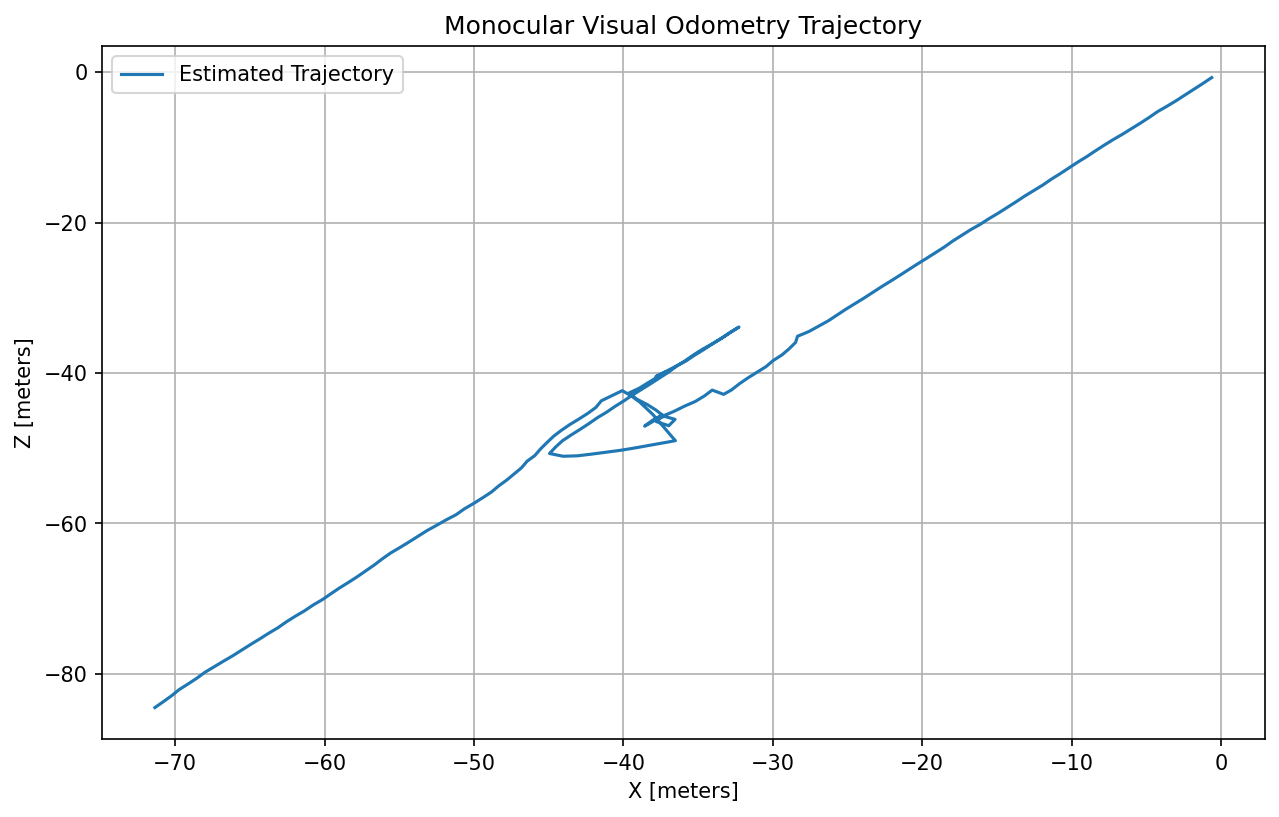

In [6]:
# Initialize feature detector and matcher
detector = cv.SIFT_create()  # You can use ORB or AKAZE instead
matcher = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Camera intrinsic parameters (assumed from the dataset; update as necessary)
focal_length = 800  # Example focal length in pixels
cx, cy = 320, 240  # Principal point (image center)
K = np.array([[focal_length, 0, cx],
              [0, focal_length, cy],
              [0, 0, 1]])

# Variables for storing trajectory and previous frame info
trajectory = np.zeros((3, 1))  # Initialize position at origin
prev_image = None
prev_kp, prev_desc = None, None

# Store trajectory for plotting
positions = []

# Loop through images in the dataset
for idx, (_, _, cam_image) in enumerate(dataset):
    print(f"Processing frame {idx}...")
    
    # Detect features in the current frame
    kp, desc = detect_and_compute_features(cam_image, detector)
    
    if prev_image is not None:
        # Match features between previous and current frame
        good_matches = match_features(prev_desc, desc, matcher)
        
        # Estimate motion using Essential Matrix and RecoverPose
        R, t = get_pose_from_matches(prev_kp, kp, good_matches, K)
        
        if R is not None and t is not None:
            # Update position (relative motion)
            trajectory += R @ t  # Accumulate motion
            
            # Store position for visualization
            positions.append(trajectory.copy().flatten())
    
    # Update previous frame data
    prev_image, prev_kp, prev_desc = cam_image, kp, desc

# Convert positions to numpy array for plotting
positions = np.array(positions)

# Plot the estimated trajectory
plt.figure(figsize=(10, 6))
plt.plot(positions[:, 0], positions[:, 2], label="Estimated Trajectory")
plt.xlabel("X [meters]")
plt.ylabel("Z [meters]")
plt.title("Monocular Visual Odometry Trajectory")
plt.legend()
plt.grid()
plt.show()

Plotting x and y:

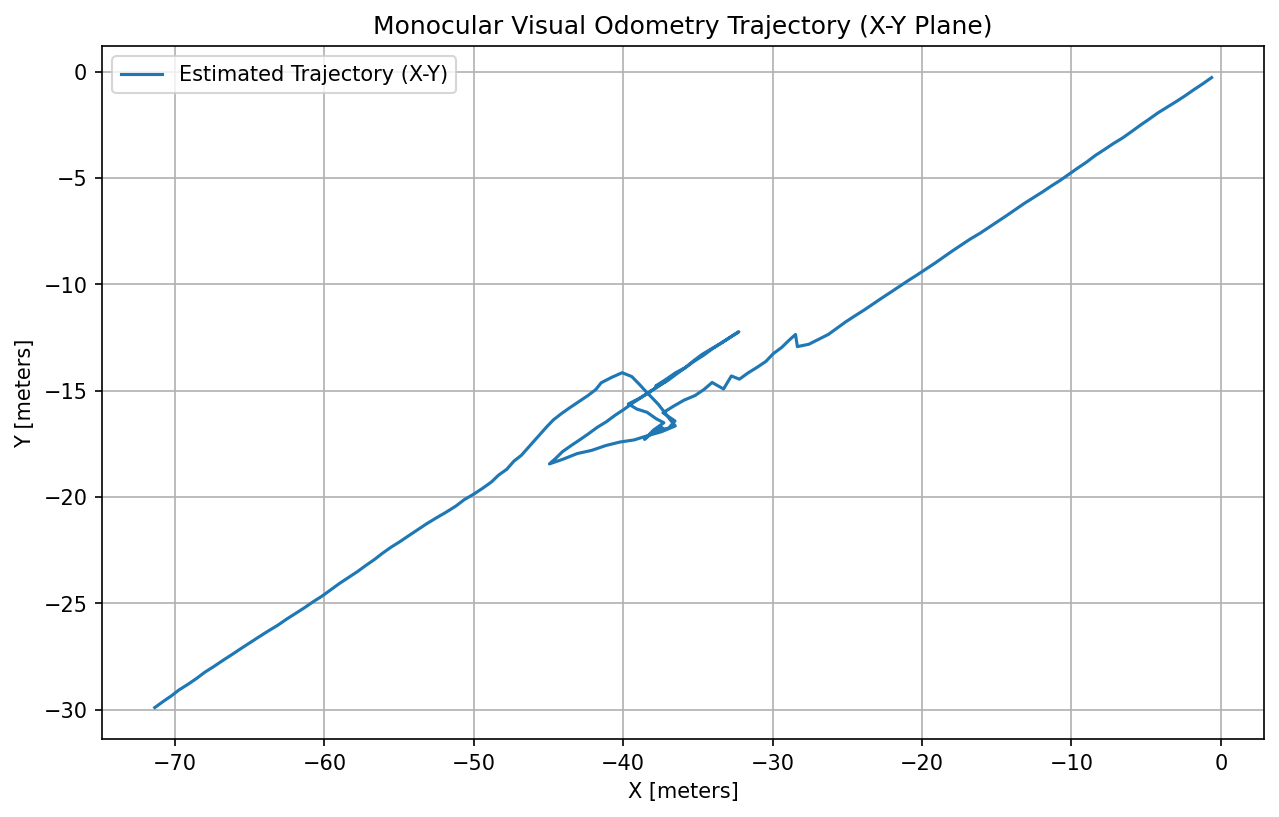

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(positions[:, 0], positions[:, 1], label="Estimated Trajectory (X-Y)")
plt.xlabel("X [meters]")
plt.ylabel("Y [meters]")
plt.title("Monocular Visual Odometry Trajectory (X-Y Plane)")
plt.legend()
plt.grid()
plt.show()

Let's get the information car `0`.

In [8]:
all_data=[]
dataset = AdverCityDataset(root=root, car=0, cam=0)
data = []
for cam_ref, cam_intrinsics, cam_image in dataset:
    data.append(cam_ref)
all_data.append(data)

Let's do the same for the remaining cars available in each scenario of this dataset.

In [9]:
dataset = AdverCityDataset(root=root, car=1, cam=0)
data = []
for cam_ref, cam_intrinsics, cam_image in dataset:
    data.append(cam_ref)
all_data.append(data)

In [10]:
dataset = AdverCityDataset(root=root, car=2, cam=0)
data = []
for cam_ref, cam_intrinsics, cam_image in dataset:
    data.append(cam_ref)
all_data.append(data)

We can now prepare some nice plots. Let's start by checking the ground truth trajectory of each car.

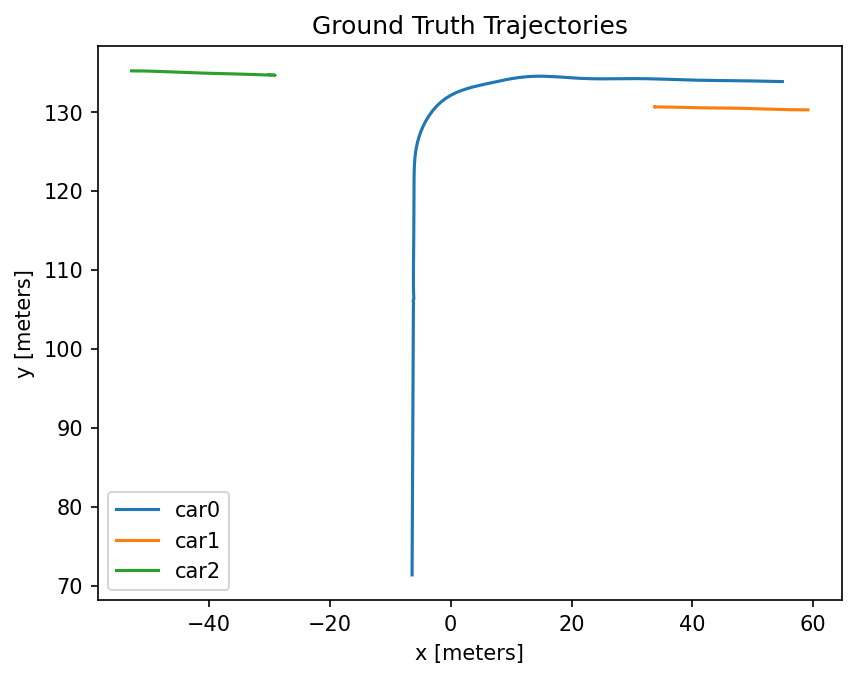

In [11]:
fig, axis = plt.subplots()

for car_data in all_data:
    # Let's convert the data to a numpy array to facilitate the access
    array = np.array(car_data)

    # Plot the trajectory. The data is a list which columns follow this order: x, y, z, roll, pitch, yaw, speed
    axis.plot(array[:, 0], array[:, 1])

axis.legend(['car0', 'car1', 'car2'])
axis.set_xlabel('x [meters]')
axis.set_ylabel('y [meters]')
axis.set_title('Ground Truth Trajectories')
plt.show()